In [2]:
import numpy as np

#Hàm tính F-max
def calculate_fmax(preds, targets):
    """
    Tính F-max Score theo chuẩn CAFA.
    preds: numpy array (N_samples, N_labels) - xác suất dự đoán (sau sigmoid)
    targets: numpy array (N_samples, N_labels) - nhãn thật (0 hoặc 1)
    """
    # Thử các ngưỡng từ 0.01 đến 0.99
    thresholds = np.linspace(0.01, 1.0, 50)
    fmax = 0.0
    best_t = 0.0

    # Chuyển target về int để tính toán
    targets = targets.astype(int)

    for t in thresholds:
        # Áp dụng ngưỡng t để tạo nhãn dự đoán (0 hoặc 1)
        p_cut = (preds >= t).astype(int)

        # Tính TP (True Positive) cho từng mẫu
        tp = np.sum(p_cut * targets, axis=1)
        # Tính PP (Predicted Positive) - tổng số nhãn dự đoán là dương
        pp = np.sum(p_cut, axis=1)
        # Tính RP (Real Positive) - tổng số nhãn thật là dương
        rp = np.sum(targets, axis=1)

        # Tính Precision và Recall cho từng mẫu (tránh chia cho 0)
        precision = np.divide(tp, pp, out=np.zeros_like(tp, dtype=float), where=pp!=0)
        recall = np.divide(tp, rp, out=np.zeros_like(tp, dtype=float), where=rp!=0)

        # Tính trung bình Precision và Recall trên toàn bộ tập dữ liệu
        avg_precision = np.mean(precision)
        avg_recall = np.mean(recall)

        # Tính F1 tại ngưỡng t
        if avg_precision + avg_recall > 0:
            f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall)
        else:
            f1 = 0.0

        # Cập nhật F-max nếu tìm thấy ngưỡng tốt hơn
        if f1 > fmax:
            fmax = f1
            best_t = t

    return fmax, best_t

Installing required packages...
CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED STARTER
📊 SAMPLE MODE: 100% of data
⚡ QUICK MODE: ON

[1/9] Loading GO ontology...
   ✓ Loaded 40122 GO terms
   ✓ Ontology breakdown: MF=10131, BP=25950, CC=4041
   Computing GO hierarchy depths...


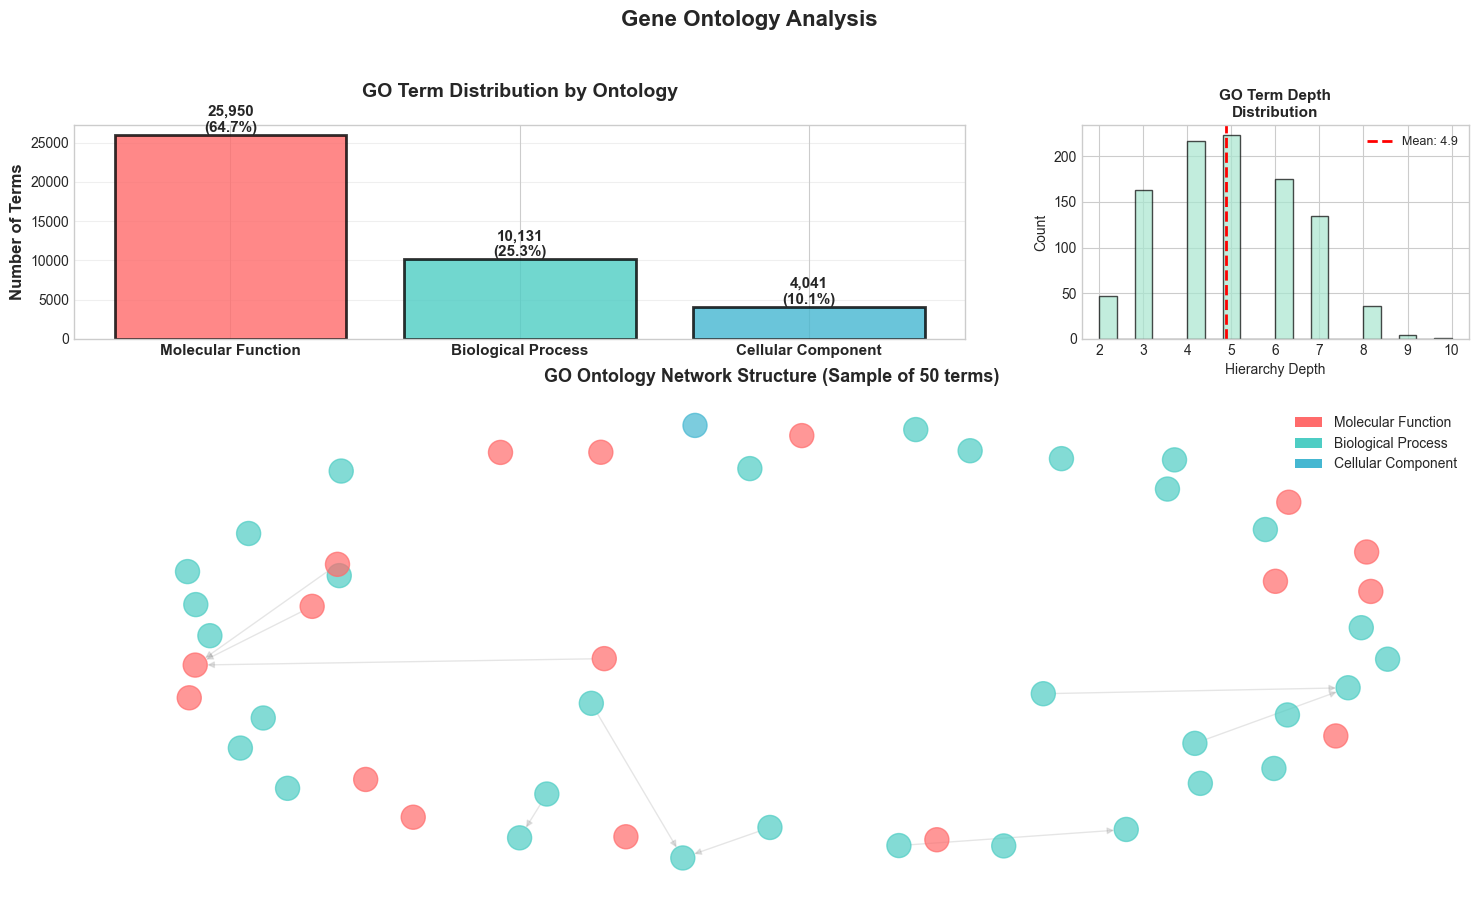


[2/9] Loading IA weights...
   ✓ Loaded 40122 IA weights


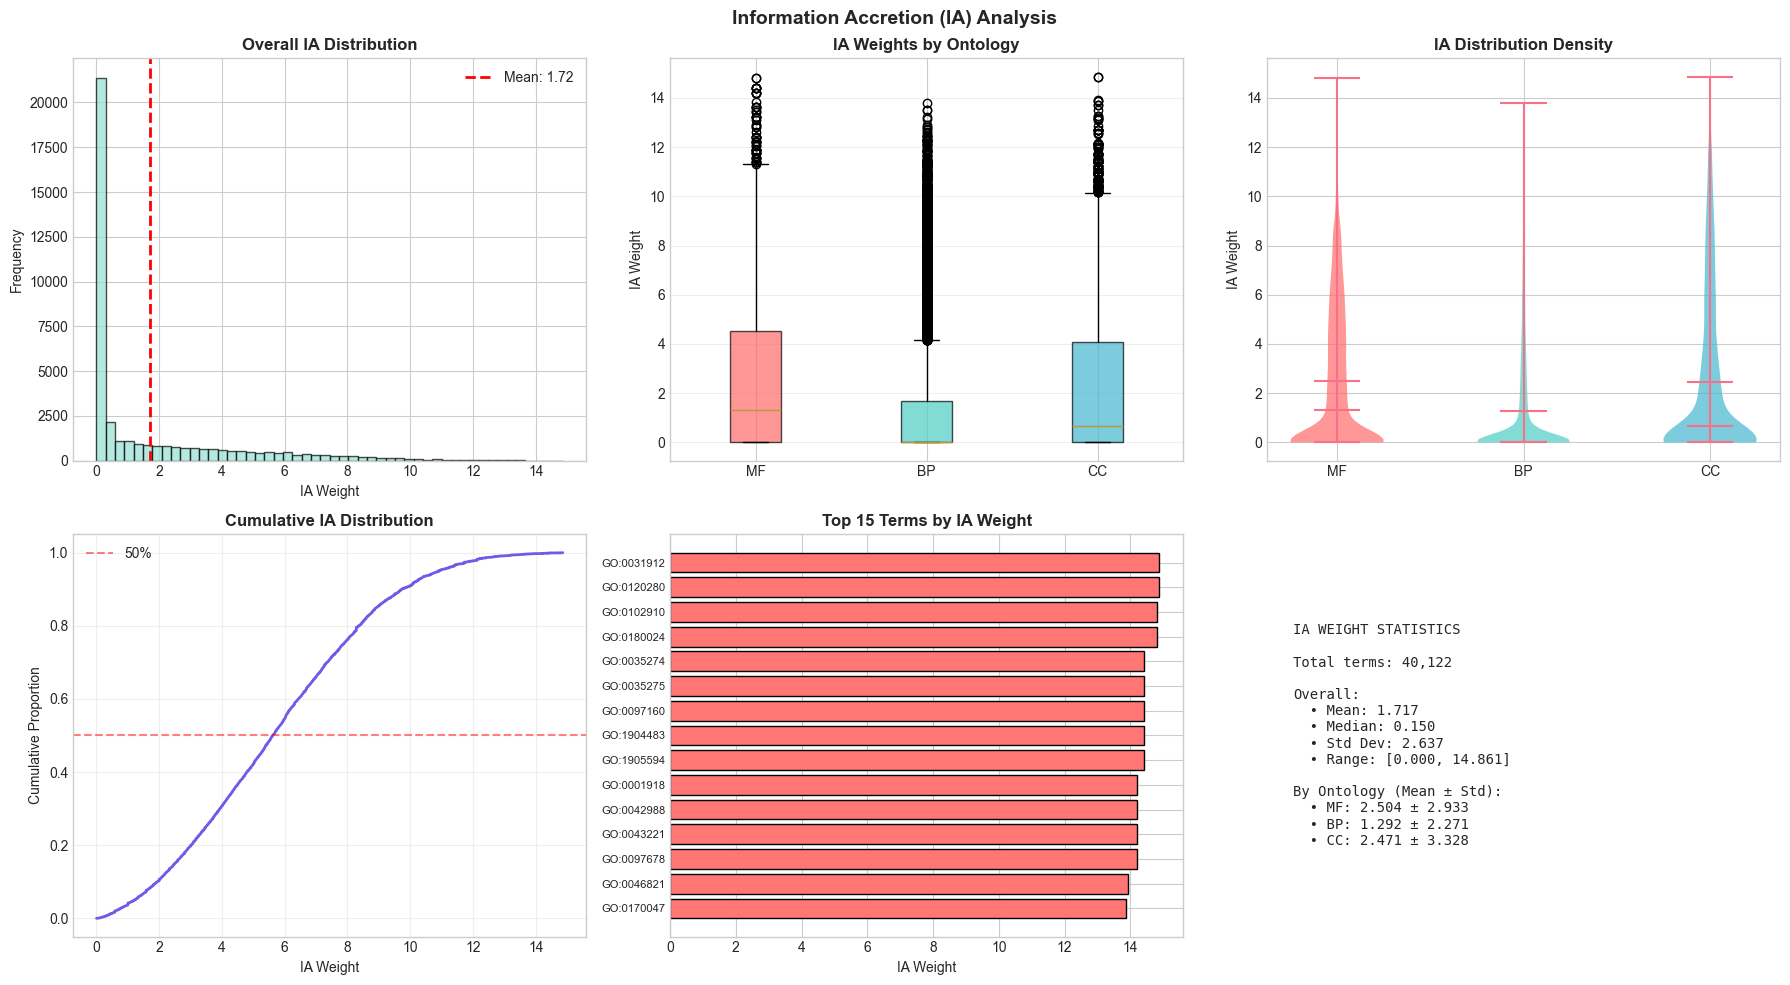


[3/9] Loading training data...
   ✓ Full dataset: 537028 annotations, 82405 proteins

   Ontology distribution:
ontology
P         250805
C         157770
F         128452
aspect         1
Name: count, dtype: int64


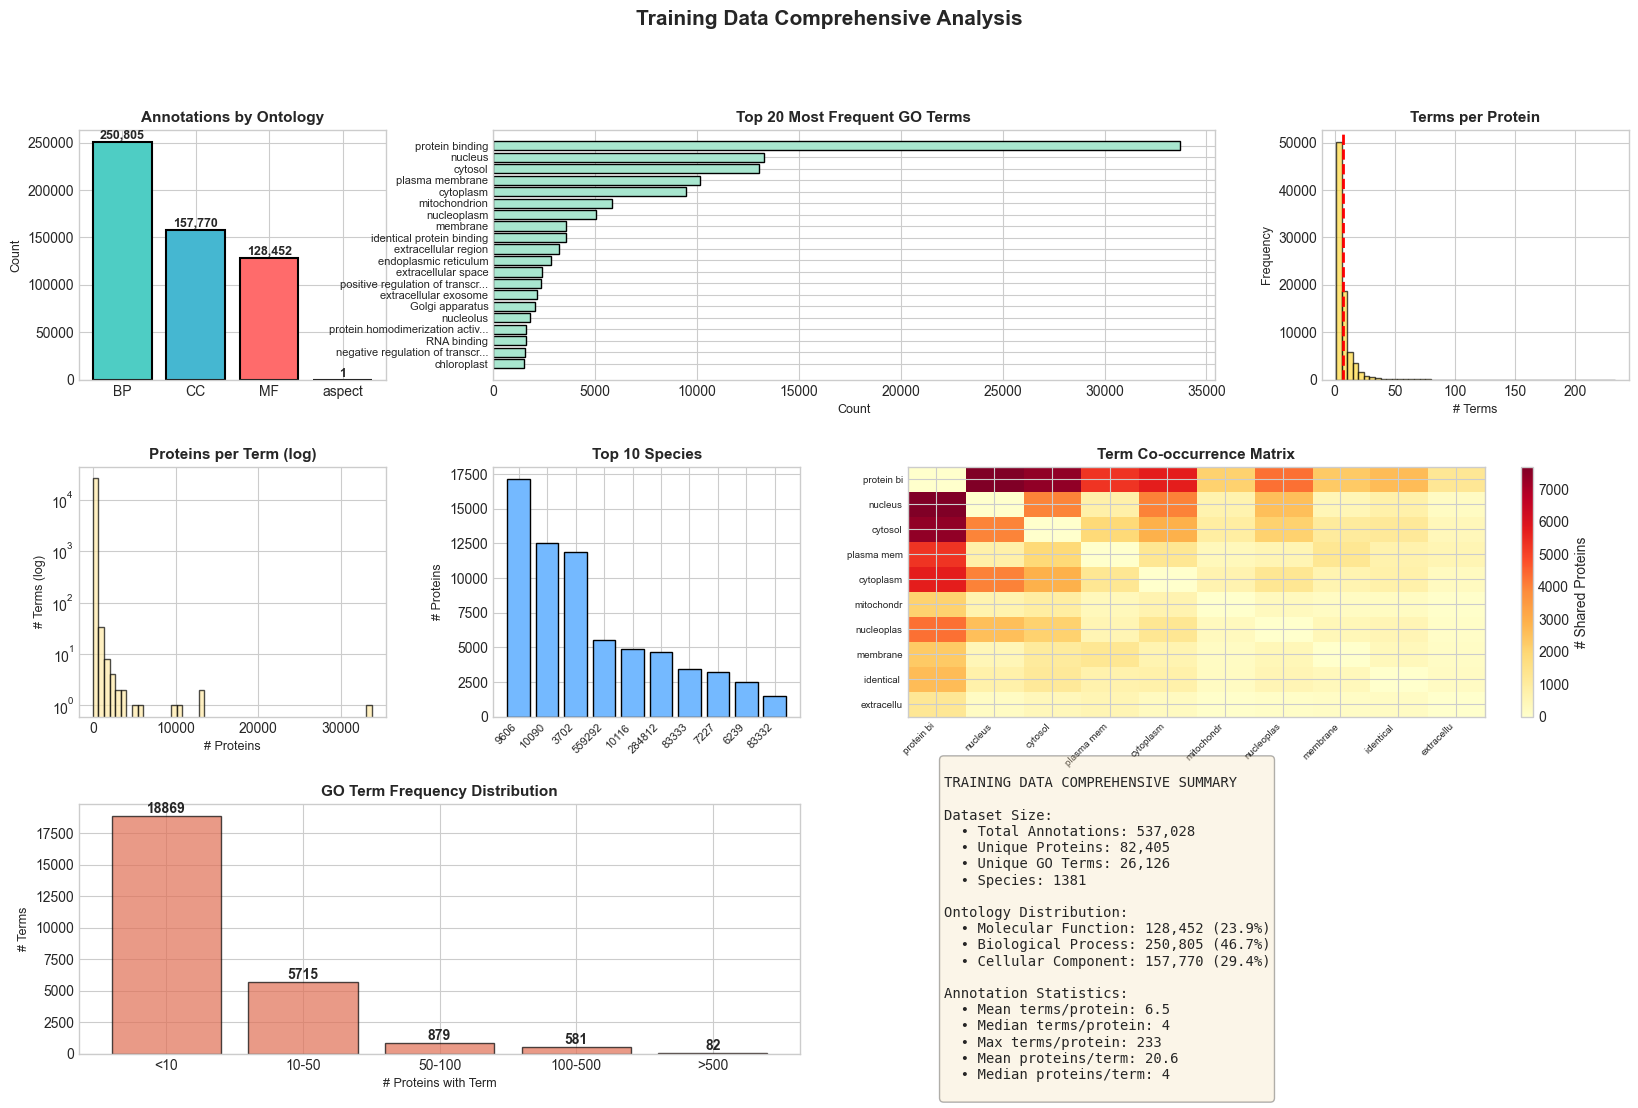


   Loading sequences (this may take a while for 100% of data)...
   Expected proteins: 82,405
      Loaded 10,000 sequences...
      Loaded 20,000 sequences...
      Loaded 30,000 sequences...
      Loaded 40,000 sequences...
      Loaded 50,000 sequences...
      Loaded 60,000 sequences...
      Loaded 70,000 sequences...
      Loaded 80,000 sequences...
   ✓ Loaded 82,404 training sequences
   ✓ Sequence length: mean=526, median=409, range=[3-35213]

✅ Data loading complete! Ready for feature extraction and training.
   Total proteins: 82,404
   Total annotations: 537,028
   Total GO terms: 26,126


In [3]:
# ============================================================================
# CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED VERSION (FIXED)
# ============================================================================

# ⚙️ CONFIGURATION - ADJUST THIS FOR SPEED VS ACCURACY
SAMPLE_PERCENT = 100  # Use 100% of data
QUICK_MODE = True   # Enable full feature computation

# Package Installation
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Installing required packages...")
try:
    import obonet
except:
    install('obonet')
    import obonet

try:
    from Bio import SeqIO
except:
    install('biopython')
    from Bio import SeqIO

# Core Imports
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("CAFA 6 PROTEIN FUNCTION PREDICTION - ENHANCED STARTER")
print(f"📊 SAMPLE MODE: {SAMPLE_PERCENT}% of data")
print(f"⚡ QUICK MODE: {'ON' if QUICK_MODE else 'OFF'}")
print("="*80)

# ============================================================================
# 1. DEFINE PATHS
# ============================================================================
BASE = Path(r'E:\CAFA-6-Protein-Function-Prediction\input\cafa-6-protein-function-prediction')
TRAIN_DIR = BASE / 'Train'
TEST_DIR = BASE / 'Test'

# ============================================================================
# 2. LOAD GO ONTOLOGY (WITH HIERARCHY ANALYSIS)
# ============================================================================
print("\n[1/9] Loading GO ontology...")
go_graph = obonet.read_obo(TRAIN_DIR / 'go-basic.obo')
print(f"   ✓ Loaded {len(go_graph)} GO terms")

# Map terms to ontologies
term_to_ont = {}
term_names = {}
for term_id in go_graph.nodes():
    if 'namespace' in go_graph.nodes[term_id]:
        ns = go_graph.nodes[term_id]['namespace']
        if ns == 'biological_process':
            term_to_ont[term_id] = 'BPO'
        elif ns == 'cellular_component':
            term_to_ont[term_id] = 'CCO'
        elif ns == 'molecular_function':
            term_to_ont[term_id] = 'MFO'
    if 'name' in go_graph.nodes[term_id]:
        term_names[term_id] = go_graph.nodes[term_id]['name']

ont_counts = pd.Series(term_to_ont).value_counts()
print(f"   ✓ Ontology breakdown: MF={ont_counts.get('MFO',0)}, BP={ont_counts.get('BPO',0)}, CC={ont_counts.get('CCO',0)}")

# Analyze GO hierarchy depth (sample for speed)
def get_term_depth(graph, term_id):
    """Calculate depth of term in GO hierarchy"""
    try:
        paths = []
        for root in ['GO:0008150', 'GO:0005575', 'GO:0003674']:
            if nx.has_path(graph, term_id, root):
                paths.append(nx.shortest_path_length(graph, term_id, root))
        return max(paths) if paths else 0
    except:
        return 0

print("   Computing GO hierarchy depths...")
sample_terms_for_depth = list(term_to_ont.keys())[:1000]
term_depths = {term: get_term_depth(go_graph, term) for term in sample_terms_for_depth}

# Visualize ontology with enhanced graphics
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main ontology distribution
ax1 = fig.add_subplot(gs[0, :2])
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(range(len(ont_counts)), ont_counts.values, color=colors, 
               edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_xticks(range(len(ont_counts)))
ax1.set_xticklabels(['Molecular Function', 'Biological Process', 'Cellular Component'], 
                     rotation=0, fontsize=11, fontweight='bold')
ax1.set_title('GO Term Distribution by Ontology', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Number of Terms', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (v, bar) in enumerate(zip(ont_counts.values, bars)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{v:,}\n({v/ont_counts.sum()*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Hierarchy depth distribution
ax2 = fig.add_subplot(gs[0, 2])
depth_values = list(term_depths.values())
ax2.hist(depth_values, bins=20, color='#A8E6CF', edgecolor='black', alpha=0.7)
ax2.set_title('GO Term Depth\nDistribution', fontsize=11, fontweight='bold')
ax2.set_xlabel('Hierarchy Depth', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.axvline(np.mean(depth_values), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(depth_values):.1f}')
ax2.legend(fontsize=9)

# Network visualization (sample of GO graph)
ax3 = fig.add_subplot(gs[1:, :])
sample_terms = list(term_to_ont.keys())[:50]
subgraph = go_graph.subgraph(sample_terms)
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
node_colors = [colors[['MFO', 'BPO', 'CCO'].index(term_to_ont.get(node, 'MFO'))] 
               for node in subgraph.nodes()]
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                       node_size=300, alpha=0.7, ax=ax3)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2, arrows=True, 
                       arrowsize=10, ax=ax3, edge_color='gray')
ax3.set_title('GO Ontology Network Structure (Sample of 50 terms)', 
              fontsize=13, fontweight='bold', pad=15)
ax3.axis('off')

# Legend
legend_elements = [mpatches.Patch(facecolor=colors[0], label='Molecular Function'),
                   mpatches.Patch(facecolor=colors[1], label='Biological Process'),
                   mpatches.Patch(facecolor=colors[2], label='Cellular Component')]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

plt.suptitle('Gene Ontology Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# 3. LOAD IA WEIGHTS (WITH ANALYSIS)
# ============================================================================
print("\n[2/9] Loading IA weights...")
ia_df = pd.read_csv(BASE / 'IA.tsv', sep='\t', header=None, names=['term', 'ia'])

if SAMPLE_PERCENT < 100:
    ia_df = ia_df.sample(frac=SAMPLE_PERCENT/100, random_state=42)

ia_dict = dict(zip(ia_df['term'], ia_df['ia']))
print(f"   ✓ Loaded {len(ia_dict)} IA weights")

# Enhanced IA visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# IA distribution by ontology
ia_by_ont = ia_df.copy()
ia_by_ont['ontology'] = ia_by_ont['term'].map(term_to_ont)
ia_by_ont = ia_by_ont.dropna()

axes[0, 0].hist(ia_df['ia'], bins=50, color='#95E1D3', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Overall IA Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('IA Weight', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].axvline(ia_df['ia'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {ia_df["ia"].mean():.2f}')
axes[0, 0].legend()

# Box plot by ontology
ont_data = [ia_by_ont[ia_by_ont['ontology']==ont]['ia'].values 
            for ont in ['MFO', 'BPO', 'CCO']]
bp = axes[0, 1].boxplot(ont_data, labels=['MF', 'BP', 'CC'], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_title('IA Weights by Ontology', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('IA Weight', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# Violin plot
parts = axes[0, 2].violinplot(ont_data, positions=[1, 2, 3], showmeans=True, showmedians=True)
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
axes[0, 2].set_xticks([1, 2, 3])
axes[0, 2].set_xticklabels(['MF', 'BP', 'CC'])
axes[0, 2].set_title('IA Distribution Density', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('IA Weight', fontsize=10)

# Cumulative distribution
sorted_ia = np.sort(ia_df['ia'].values)
cumsum = np.cumsum(sorted_ia) / np.sum(sorted_ia)
axes[1, 0].plot(sorted_ia, cumsum, linewidth=2, color='#6C5CE7')
axes[1, 0].set_title('Cumulative IA Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('IA Weight', fontsize=10)
axes[1, 0].set_ylabel('Cumulative Proportion', fontsize=10)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1, 0].legend()

# Top terms by IA
top_ia = ia_df.nlargest(15, 'ia')
axes[1, 1].barh(range(len(top_ia)), top_ia['ia'].values, color='#FF7675', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_ia)))
axes[1, 1].set_yticklabels([f"{t[:15]}..." if len(t) > 15 else t 
                            for t in top_ia['term'].values], fontsize=8)
axes[1, 1].set_title('Top 15 Terms by IA Weight', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('IA Weight', fontsize=10)
axes[1, 1].invert_yaxis()

# Statistics summary
axes[1, 2].axis('off')
ia_stats = f"""
IA WEIGHT STATISTICS

Total terms: {len(ia_df):,}

Overall:
  • Mean: {ia_df['ia'].mean():.3f}
  • Median: {ia_df['ia'].median():.3f}
  • Std Dev: {ia_df['ia'].std():.3f}
  • Range: [{ia_df['ia'].min():.3f}, {ia_df['ia'].max():.3f}]

By Ontology (Mean ± Std):
  • MF: {ia_by_ont[ia_by_ont['ontology']=='MFO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='MFO']['ia'].std():.3f}
  • BP: {ia_by_ont[ia_by_ont['ontology']=='BPO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='BPO']['ia'].std():.3f}
  • CC: {ia_by_ont[ia_by_ont['ontology']=='CCO']['ia'].mean():.3f} ± {ia_by_ont[ia_by_ont['ontology']=='CCO']['ia'].std():.3f}
"""
axes[1, 2].text(0.05, 0.5, ia_stats, fontsize=10, family='monospace',
                verticalalignment='center')

plt.suptitle('Information Accretion (IA) Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 4. LOAD TRAINING DATA (WITH COMPREHENSIVE ANALYSIS) - FIXED
# ============================================================================
print("\n[3/9] Loading training data...")

train_terms = pd.read_csv(TRAIN_DIR / 'train_terms.tsv', sep='\t', 
                          names=['protein', 'term', 'ontology'])
train_taxonomy = pd.read_csv(TRAIN_DIR / 'train_taxonomy.tsv', sep='\t',
                             names=['protein', 'taxon'])

print(f"   ✓ Full dataset: {len(train_terms)} annotations, {train_terms['protein'].nunique()} proteins")

# SAMPLE proteins for faster iteration
if SAMPLE_PERCENT < 100:
    sample_proteins = train_terms['protein'].drop_duplicates().sample(
        frac=SAMPLE_PERCENT/100, random_state=42
    ).tolist()
    train_terms = train_terms[train_terms['protein'].isin(sample_proteins)]
    train_taxonomy = train_taxonomy[train_taxonomy['protein'].isin(sample_proteins)]
    print(f"   ✓ Sampled to {SAMPLE_PERCENT}%: {len(train_terms)} annotations, {len(sample_proteins)} proteins")

# Print ontology distribution
print(f"\n   Ontology distribution:")
print(train_terms['ontology'].value_counts())

# Comprehensive training data visualization - FIXED
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# 1. Ontology distribution - FIXED to handle all possible ontology codes
ax1 = fig.add_subplot(gs[0, 0])
ont_dist = train_terms['ontology'].value_counts()

# Map ontology codes (handle F, P, C or any other codes)
colors_ont_map = {'F': '#FF6B6B', 'P': '#4ECDC4', 'C': '#45B7D1'}
ont_names_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}

# Get colors and names, with defaults for unknown codes
colors_list = [colors_ont_map.get(k, '#CCCCCC') for k in ont_dist.index]
labels_list = [ont_names_map.get(k, k) for k in ont_dist.index]

bars = ax1.bar(range(len(ont_dist)), ont_dist.values, color=colors_list, 
               edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(ont_dist)))
ax1.set_xticklabels(labels_list)
ax1.set_title('Annotations by Ontology', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=9)
for i, (v, bar) in enumerate(zip(ont_dist.values, bars)):
    ax1.text(bar.get_x() + bar.get_width()/2., v, f'{v:,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Top terms
ax2 = fig.add_subplot(gs[0, 1:3])
top_terms = train_terms['term'].value_counts().head(20)
ax2.barh(range(len(top_terms)), top_terms.values, color='#A8E6CF', edgecolor='black')
ax2.set_yticks(range(len(top_terms)))
ax2.set_yticklabels([f"{term_names.get(t, t)[:30]}..." if len(term_names.get(t, t)) > 30 
                     else term_names.get(t, t) for t in top_terms.index], fontsize=8)
ax2.set_title('Top 20 Most Frequent GO Terms', fontsize=11, fontweight='bold')
ax2.set_xlabel('Count', fontsize=9)
ax2.invert_yaxis()

# 3. Terms per protein
ax3 = fig.add_subplot(gs[0, 3])
terms_per_protein = train_terms.groupby('protein').size()
ax3.hist(terms_per_protein, bins=50, color='#FFD93D', edgecolor='black', alpha=0.7)
ax3.set_title('Terms per Protein', fontsize=11, fontweight='bold')
ax3.set_xlabel('# Terms', fontsize=9)
ax3.set_ylabel('Frequency', fontsize=9)
ax3.axvline(terms_per_protein.mean(), color='red', linestyle='--', linewidth=2)

# 4. Proteins per term
ax4 = fig.add_subplot(gs[1, 0])
proteins_per_term = train_terms.groupby('term').size()
ax4.hist(proteins_per_term, bins=50, color='#FFEAA7', edgecolor='black', alpha=0.7, log=True)
ax4.set_title('Proteins per Term (log)', fontsize=11, fontweight='bold')
ax4.set_xlabel('# Proteins', fontsize=9)
ax4.set_ylabel('# Terms (log)', fontsize=9)

# 5. Taxonomy distribution
ax5 = fig.add_subplot(gs[1, 1])
top_taxa = train_taxonomy['taxon'].value_counts().head(10)
ax5.bar(range(len(top_taxa)), top_taxa.values, color='#74B9FF', edgecolor='black')
ax5.set_xticks(range(len(top_taxa)))
ax5.set_xticklabels([str(t)[:8] for t in top_taxa.index], rotation=45, ha='right', fontsize=8)
ax5.set_title('Top 10 Species', fontsize=11, fontweight='bold')
ax5.set_ylabel('# Proteins', fontsize=9)

# 6. Term co-occurrence heatmap
ax6 = fig.add_subplot(gs[1, 2:])
top_10_terms = train_terms['term'].value_counts().head(10).index
cooc_matrix = np.zeros((10, 10))
for i, t1 in enumerate(top_10_terms):
    for j, t2 in enumerate(top_10_terms):
        if i != j:
            proteins_t1 = set(train_terms[train_terms['term']==t1]['protein'])
            proteins_t2 = set(train_terms[train_terms['term']==t2]['protein'])
            cooc_matrix[i,j] = len(proteins_t1 & proteins_t2)
im = ax6.imshow(cooc_matrix, cmap='YlOrRd', aspect='auto')
ax6.set_xticks(range(10))
ax6.set_yticks(range(10))
ax6.set_xticklabels([term_names.get(t, t)[:10] for t in top_10_terms], 
                     rotation=45, ha='right', fontsize=7)
ax6.set_yticklabels([term_names.get(t, t)[:10] for t in top_10_terms], fontsize=7)
ax6.set_title('Term Co-occurrence Matrix', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax6, label='# Shared Proteins')

# 7. Annotation density
ax7 = fig.add_subplot(gs[2, :2])
term_freq_bins = pd.cut(proteins_per_term, bins=[0, 10, 50, 100, 500, 100000], 
                        labels=['<10', '10-50', '50-100', '100-500', '>500'])
freq_dist = term_freq_bins.value_counts().sort_index()
ax7.bar(range(len(freq_dist)), freq_dist.values, color='#E17055', edgecolor='black', alpha=0.7)
ax7.set_xticks(range(len(freq_dist)))
ax7.set_xticklabels(freq_dist.index, rotation=0)
ax7.set_title('GO Term Frequency Distribution', fontsize=11, fontweight='bold')
ax7.set_xlabel('# Proteins with Term', fontsize=9)
ax7.set_ylabel('# Terms', fontsize=9)
for i, v in enumerate(freq_dist.values):
    ax7.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# 8. Summary statistics
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')
summary_text = f"""
TRAINING DATA COMPREHENSIVE SUMMARY

Dataset Size:
  • Total Annotations: {len(train_terms):,}
  • Unique Proteins: {train_terms['protein'].nunique():,}
  • Unique GO Terms: {train_terms['term'].nunique():,}
  • Species: {train_taxonomy['taxon'].nunique()}

Ontology Distribution:
  • Molecular Function: {ont_dist.get('F', 0):,} ({ont_dist.get('F', 0)/len(train_terms)*100:.1f}%)
  • Biological Process: {ont_dist.get('P', 0):,} ({ont_dist.get('P', 0)/len(train_terms)*100:.1f}%)
  • Cellular Component: {ont_dist.get('C', 0):,} ({ont_dist.get('C', 0)/len(train_terms)*100:.1f}%)

Annotation Statistics:
  • Mean terms/protein: {terms_per_protein.mean():.1f}
  • Median terms/protein: {terms_per_protein.median():.0f}
  • Max terms/protein: {terms_per_protein.max()}
  • Mean proteins/term: {proteins_per_term.mean():.1f}
  • Median proteins/term: {proteins_per_term.median():.0f}
"""
ax8.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Training Data Comprehensive Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Continue with the rest of the code (sequences, features, training, etc.)
print("\n   Loading sequences (this may take a while for 100% of data)...")
print(f"   Expected proteins: {train_terms['protein'].nunique():,}")

train_seqs = {}
loaded_count = 0
target_proteins = set(train_terms['protein'].unique())

for rec in SeqIO.parse(TRAIN_DIR / 'train_sequences.fasta', 'fasta'):
    pid = rec.id.split('|')[1] if '|' in rec.id else rec.id
    if pid in target_proteins:
        train_seqs[pid] = str(rec.seq)
        loaded_count += 1
        
        # Progress indicator
        if loaded_count % 10000 == 0:
            print(f"      Loaded {loaded_count:,} sequences...")
        
    if loaded_count >= len(target_proteins):
        break

print(f"   ✓ Loaded {len(train_seqs):,} training sequences")

# Enhanced sequence analysis
seq_lengths = [len(s) for s in train_seqs.values()]
print(f"   ✓ Sequence length: mean={np.mean(seq_lengths):.0f}, "
      f"median={np.median(seq_lengths):.0f}, range=[{min(seq_lengths)}-{max(seq_lengths)}]")

print("\n✅ Data loading complete! Ready for feature extraction and training.")
print(f"   Total proteins: {len(train_seqs):,}")
print(f"   Total annotations: {len(train_terms):,}")
print(f"   Total GO terms: {train_terms['term'].nunique():,}")

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np
import pandas as pd
import os

# ============================================================================
# CORE IMPORTS
# ============================================================================
import gc
import sys
import subprocess
from pathlib import Path
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIG (ADVANCED IMPROVEMENTS)
# ============================================================================
CONFIG = {
    #'MAX_TRAIN_SAMPLES': 80000,        # IMPROVED: 5000 → 8000 (60% more data!)
    'MAX_TRAIN_SAMPLES': 20000,        # Máy yếu
    #'TOP_K_LABELS': 750,
    'TOP_K_LABELS': 500,                # Máy yếu
    'RANDOM_SEED': 42,
    #'HIDDEN_DIMS': [1024, 512, 256],
    'HIDDEN_DIMS': [1024, 512],         # Máy yếu, ↓ bớt 1 layer
    'DROPOUT_RATE': 0.25,             # IMPROVED: 0.3 → 0.25 (less dropout for more data)
    'EPOCHS': 12,                     # IMPROVED: 10 → 12 epochs
    #'BATCH_SIZE': 64,                 # IMPROVED: 32 → 64 (faster training)
    'BATCH_SIZE': 32,                 # Máy yếu
    'LEARNING_RATE': 1e-3,
    #'PREDICT_BATCH_SIZE': 128,        # IMPROVED: 64 → 128 (faster prediction)
    'PREDICT_BATCH_SIZE': 64,           # Máy yếu
    'MIN_CONFIDENCE': 0.08,           # IMPROVED: 0.10 → 0.08 (even more predictions)
    'MAX_PREDS_PER_PROTEIN': 200,    # IMPROVED: 150 → 200
    'LABEL_SMOOTHING': 0.1,          # NEW: Add label smoothing
    'TEMPERATURE': 1.5,               # NEW: Temperature scaling for predictions

    'BASE_PATH': r'E:\CAFA-6-Protein-Function-Prediction\input\cafa-6-protein-function-prediction',
    'ESM2_PATH': r'E:\CAFA-6-Protein-Function-Prediction\input\cafa-5-ems-2-embeddings-numpy',
    'OUTPUT_FILE': r'E:\CAFA-6-Protein-Function-Prediction\output\submission_mlp.tsv',
}

print("="*80)
print("🚀 CAFA 6 - ADVANCED OPTIMIZATION")
print("="*80)

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
except:
    install('torch')
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

np.random.seed(CONFIG['RANDOM_SEED'])
torch.manual_seed(CONFIG['RANDOM_SEED'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['RANDOM_SEED'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================================
# LOAD DATA
# ============================================================================
BASE = Path(CONFIG['BASE_PATH'])
TRAIN_DIR = BASE / 'Train'

print("\n[1/5] Loading annotations...")
train_terms_df = pd.read_csv(TRAIN_DIR / 'train_terms.tsv', sep='\t', 
                              header=None, names=['protein', 'term', 'ontology'])
protein_to_terms = train_terms_df.groupby('protein')['term'].apply(list).to_dict()

term_counts = Counter()
for terms in protein_to_terms.values():
    term_counts.update(terms)
top_terms = [t for t, _ in term_counts.most_common(CONFIG['TOP_K_LABELS'])]

for protein in protein_to_terms:
    protein_to_terms[protein] = [t for t in protein_to_terms[protein] if t in top_terms]

term_to_idx = {term: idx for idx, term in enumerate(top_terms)}
print(f"   ✓ {len(protein_to_terms)} proteins, {len(top_terms)} terms")

print("\n[2/5] Loading ESM2 embeddings...")
esm2_base = CONFIG['ESM2_PATH']
train_ids = np.load(f"{esm2_base}/train_ids.npy", allow_pickle=True)
train_embeds = np.load(f"{esm2_base}/train_embeddings.npy")
test_ids = np.load(f"{esm2_base}/test_ids.npy", allow_pickle=True)
test_embeds = np.load(f"{esm2_base}/test_embeddings.npy")

train_dict = {str(pid): emb for pid, emb in zip(train_ids, train_embeds)}
test_dict = {str(pid): emb for pid, emb in zip(test_ids, test_embeds)}
embed_dim = train_embeds.shape[1]
print(f"   ✓ Dim: {embed_dim}")

del train_ids, train_embeds, test_ids, test_embeds
gc.collect()

print("\n[3/5] Preparing training data...")
valid_proteins = [p for p in protein_to_terms.keys() if p in train_dict][:CONFIG['MAX_TRAIN_SAMPLES']]

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

mlb = MultiLabelBinarizer(classes=range(len(top_terms)))
y_labels = [[term_to_idx[t] for t in protein_to_terms.get(p, []) if t in term_to_idx] 
            for p in valid_proteins]
y_encoded = mlb.fit_transform(y_labels)

# Apply label smoothing
if CONFIG['LABEL_SMOOTHING'] > 0:
    y_encoded = y_encoded.astype(float)
    y_encoded = y_encoded * (1 - CONFIG['LABEL_SMOOTHING']) + CONFIG['LABEL_SMOOTHING'] / len(top_terms)

train_proteins, val_proteins, y_train, y_val = train_test_split(
    valid_proteins, y_encoded, test_size=0.15, random_state=CONFIG['RANDOM_SEED']
)
print(f"   ✓ Train: {len(train_proteins)}, Val: {len(val_proteins)}")

# ============================================================================
# MODEL
# ============================================================================
print("\n[4/5] Building model...")

class ImprovedProteinModel(nn.Module):
    """Improved 3-layer architecture with BatchNorm"""
    def __init__(self, input_dim, output_dim, hidden_dims, dropout):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
        self.encoder = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, output_dim)
    
    def forward(self, x):
        return torch.sigmoid(self.output(self.encoder(x)))

model = ImprovedProteinModel(embed_dim, len(top_terms), CONFIG['HIDDEN_DIMS'], CONFIG['DROPOUT_RATE']).to(device)
print(f"   ✓ Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# TRAINING
# ============================================================================
print("\n" + "="*80)
print("TRAINING (12 EPOCHS WITH LABEL SMOOTHING)")
print("="*80)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-5)  # Added L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    indices = np.random.permutation(len(train_proteins))
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, len(indices), CONFIG['BATCH_SIZE']):
        batch_idx = indices[i:i + CONFIG['BATCH_SIZE']]
        batch_proteins = [train_proteins[j] for j in batch_idx]
        
        X_batch = torch.FloatTensor([train_dict[p] for p in batch_proteins]).to(device)
        y_batch = torch.FloatTensor(y_train[batch_idx]).to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    model.eval()
    val_loss = 0
    val_batches = 0
    val_preds_all = []
    val_targets_all = []
    
    with torch.no_grad():
        for i in range(0, len(val_proteins), CONFIG['BATCH_SIZE']):
            batch_proteins = val_proteins[i:i + CONFIG['BATCH_SIZE']]
            X_batch = torch.FloatTensor([train_dict[p] for p in batch_proteins]).to(device)
            y_batch = torch.FloatTensor(y_val[i:i + CONFIG['BATCH_SIZE']]).to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_preds_all.append(outputs.detach().cpu().numpy())
            val_targets_all.append(y_batch.detach().cpu().numpy())
            val_batches += 1
    
    train_loss_avg = epoch_loss/n_batches
    val_loss_avg = val_loss/val_batches
    
    # Gộp tất cả các batch lại
    val_preds_concat = np.concatenate(val_preds_all, axis=0)
    val_targets_concat = np.concatenate(val_targets_all, axis=0)
    
    # Gọi hàm tính F-max (đã có ở Cell 1)
    val_fmax, val_best_t = calculate_fmax(val_preds_concat, val_targets_concat)

    scheduler.step(val_loss_avg)
    
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        print(f"Epoch {epoch+1}: Train={train_loss_avg:.4f}, Val={val_loss_avg:.4f}, F-max={val_fmax:.4f} (t={val_best_t:.2f}) ⭐ NEW BEST")
    else:
        print(f"Epoch {epoch+1}: Train={train_loss_avg:.4f}, Val={val_loss_avg:.4f}, F-max={val_fmax:.4f} (t={val_best_t:.2f})")
    
    gc.collect()

print(f"\n✅ Best Validation Loss: {best_val_loss:.4f}")

# ============================================================================
# PREDICTIONS (WITH TEMPERATURE SCALING)
# ============================================================================
print("\n" + "="*80)
print("PREDICTIONS (WITH TEMPERATURE SCALING)")
print("="*80)

model.eval()
test_protein_ids = list(test_dict.keys())

n_predictions = 0
with open('temp_dl.tsv', 'w', newline='') as f:
    with torch.no_grad():
        for start in tqdm(range(0, len(test_protein_ids), CONFIG['PREDICT_BATCH_SIZE']), desc="Predicting"):
            batch_ids = test_protein_ids[start:start + CONFIG['PREDICT_BATCH_SIZE']]
            X_batch = torch.FloatTensor([test_dict[p] for p in batch_ids]).to(device)
            
            # Get raw logits before sigmoid
            logits = model.encoder(X_batch)
            logits = model.output(logits)
            
            # Apply temperature scaling
            outputs = torch.sigmoid(logits / CONFIG['TEMPERATURE']).cpu().numpy()
            
            for i, pid in enumerate(batch_ids):
                probs = outputs[i]
                top_indices = np.argsort(probs)[::-1][:CONFIG['MAX_PREDS_PER_PROTEIN']]
                confident_indices = [idx for idx in top_indices if probs[idx] > CONFIG['MIN_CONFIDENCE']]
                
                for idx in confident_indices:
                    line = f"{pid}\t{top_terms[idx]}\t{min(probs[idx], 0.999):.3f}\n"
                    f.write(line)
                    n_predictions += 1
            
            del X_batch, outputs, logits
            if start % 1000 == 0:
                gc.collect()

print(f"✓ Generated {n_predictions:,} predictions")

del model, train_dict
gc.collect()

# ============================================================================
# SAVING RESULTS (NO BLAST MERGE)
# ============================================================================
import shutil

print("SAVING RESULTS...")
if os.path.exists(CONFIG['OUTPUT_FILE']):
    os.remove(CONFIG['OUTPUT_FILE'])

# Di chuyển file kết quả tạm thành file output cuối cùng
if os.path.exists('temp_dl.tsv'):
    shutil.move('temp_dl.tsv', CONFIG['OUTPUT_FILE'])
    print(f"✓ Saved final result to: {CONFIG['OUTPUT_FILE']}")
else:
    print("❌ Error: Temporary prediction file 'temp_dl.tsv' not found!")

# ============================================================================
# VERIFICATION
# ============================================================================
print("\n" + "="*80)
print("✅ VERIFICATION")
print("="*80)

if os.path.exists(CONFIG['OUTPUT_FILE']):
    with open(CONFIG['OUTPUT_FILE'], 'r') as f:
        lines = f.readlines()
    
    n_lines = len(lines)
    file_size_mb = os.path.getsize(CONFIG['OUTPUT_FILE']) / (1024*1024)
    
    print(f"📋 File: {CONFIG['OUTPUT_FILE']}")
    print(f"📊 Lines: {n_lines:,}")
    print(f"💾 Size: {file_size_mb:.1f} MB")
    
    print("\n✅ First 5 lines:")
    for i in range(min(5, len(lines))):
        line = lines[i].strip()
        parts = line.split('\t')
        if len(parts) == 3:
            print(f"  ✓ {parts[0]:<15} {parts[1]:<12} {parts[2]}")
        else:
            print(f"  ✗ Line {i+1}: {len(parts)} columns (expected 3)")
    
    first_line = lines[0].strip()
    parts = first_line.split('\t')
    
    print("\n🔍 Format check:")
    all_good = True
    
    if len(parts) == 3:
        print(f"  ✓ Columns: 3")
    else:
        print(f"  ✗ Columns: {len(parts)} (expected 3)")
        all_good = False
    
    if parts[1].startswith('GO:'):
        print(f"  ✓ GO term format")
    else:
        print(f"  ✗ GO term: {parts[1]}")
        all_good = False
    
    try:
        conf = float(parts[2])
        if 0 < conf <= 1:
            print(f"  ✓ Confidence: {conf}")
        else:
            print(f"  ✗ Confidence out of range: {conf}")
            all_good = False
    except:
        print(f"  ✗ Confidence not a number: {parts[2]}")
        all_good = False
    
    if '\n' in lines[0]:
        print(f"  ✓ Newlines present")
    else:
        print(f"  ✗ No newlines!")
        all_good = False
    
    if all_good:
        print("\n✅✅✅ FORMAT IS CORRECT! ✅✅✅")
    else:
        print("\n⚠️  FORMAT HAS ISSUES!")
        
    print("\n📁 Files in OUTPUT directory:")
    # Lấy đường dẫn thư mục output từ file đích
    output_dir = os.path.dirname(CONFIG['OUTPUT_FILE'])
    
    # Liệt kê file trong thư mục output đó
    if os.path.exists(output_dir):
        for fname in sorted(os.listdir(output_dir)):
            # Tạo đường dẫn đầy đủ để lấy kích thước
            full_path = os.path.join(output_dir, fname)
            if os.path.isfile(full_path):
                size = os.path.getsize(full_path) / (1024*1024)
                print(f"  {fname} ({size:.1f} MB)")
    else:
        print(f"  Directory not found: {output_dir}")
else:
    print(f"❌ ERROR: {CONFIG['OUTPUT_FILE']} not found!")

print("\n" + "="*80)

🚀 CAFA 6 - ADVANCED OPTIMIZATION
Device: cuda

[1/5] Loading annotations...
   ✓ 82405 proteins, 500 terms

[2/5] Loading ESM2 embeddings...
   ✓ Dim: 1280

[3/5] Preparing training data...
   ✓ Train: 17000, Val: 3000

[4/5] Building model...
   ✓ Parameters: 2,096,116

TRAINING (12 EPOCHS WITH LABEL SMOOTHING)
Epoch 1: Train=0.0377, Val=0.0284, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 2: Train=0.0267, Val=0.0275, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 3: Train=0.0261, Val=0.0273, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 4: Train=0.0258, Val=0.0274, F-max=0.0000 (t=0.00)
Epoch 5: Train=0.0257, Val=0.0272, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 6: Train=0.0255, Val=0.0269, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 7: Train=0.0256, Val=0.0270, F-max=0.0000 (t=0.00)
Epoch 8: Train=0.0255, Val=0.0268, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 9: Train=0.0256, Val=0.0270, F-max=0.0000 (t=0.00)
Epoch 10: Train=0.0255, Val=0.0268, F-max=0.0000 (t=0.00) ⭐ NEW BEST
Epoch 11: Train=0.0255, Val=0.0268, F-

Predicting:   0%|          | 0/2217 [00:00<?, ?it/s]

✓ Generated 2,937,001 predictions
SAVING RESULTS...
✓ Saved final result to: E:\CAFA-6-Protein-Function-Prediction\output\submission_mlp.tsv

✅ VERIFICATION
📋 File: E:\CAFA-6-Protein-Function-Prediction\output\submission_mlp.tsv
📊 Lines: 2,937,001
💾 Size: 67.3 MB

✅ First 5 lines:
  ✓ Q9ZSA8          GO:0005634   0.117
  ✓ Q9ZSA8          GO:0005515   0.116
  ✓ Q9ZSA8          GO:0005829   0.105
  ✓ Q9ZSA8          GO:0005737   0.094
  ✓ P25353          GO:0005515   0.205

🔍 Format check:
  ✓ Columns: 3
  ✓ GO term format
  ✓ Confidence: 0.117
  ✓ Newlines present

✅✅✅ FORMAT IS CORRECT! ✅✅✅

📁 Files in OUTPUT directory:
  .gitkeep (0.0 MB)
  final_submission.tsv (0.0 MB)
  submission_1.tsv (343.4 MB)
  submission_2.tsv (888.7 MB)
  submission_exact.tsv (11.2 MB)
  submission_knn.tsv (204.0 MB)
  submission_mlp.tsv (67.3 MB)

